## Pytorch Linear Regression

Credit: https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

Input data will be in the following format for each restaurant business:
- food positive sentiment
- food negative sentiment
- service positive sentiment
- service negative sentiment
- location positive sentiment
- location negative sentiment
- cleanliness positive sentiment
- cleanliness negative sentiment
- price positive sentiment
- price negative sentiment

We want to predict the rating between 1 and 5 stars.

In [1]:
import numpy as np
import pandas as pd
import torch
import json
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
# Load JSON data
with open('restaurant-topic-sentiment.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()

# Calculate the size of train and test splits
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Split the dataset
train_data, test_data = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the last column (index -1) is the label 'rating'
        x = self.data[idx, :-1]
        y = self.data[idx, -1]
        return x, y

# Create datasets and dataloaders
train_dataset = CustomDataset(np.array(train_data))
test_dataset = CustomDataset(np.array(test_data))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [3]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [4]:
inputDim = 10
outputDim = 1
learningRate = .01
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

linearRegression(
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [5]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
mse_history = []

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

    # Calculate MSE for this epoch and store it
    with torch.no_grad():
        epoch_losses = []
        for inputs, labels in train_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            outputs = model(inputs)
            epoch_loss = criterion(outputs.view(-1), labels)
            epoch_losses.append(epoch_loss.item())
        mse_history.append(np.mean(epoch_losses))

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {mse_history[-1]:.4f}')

Epoch [1/100], Loss: 0.9841
Epoch [2/100], Loss: 0.6206
Epoch [3/100], Loss: 0.5295
Epoch [4/100], Loss: 0.4556
Epoch [5/100], Loss: 0.3969
Epoch [6/100], Loss: 0.3477
Epoch [7/100], Loss: 0.3122
Epoch [8/100], Loss: 0.2761
Epoch [9/100], Loss: 0.2481
Epoch [10/100], Loss: 0.2261
Epoch [11/100], Loss: 0.2054
Epoch [12/100], Loss: 0.1908
Epoch [13/100], Loss: 0.1747
Epoch [14/100], Loss: 0.1628
Epoch [15/100], Loss: 0.1524
Epoch [16/100], Loss: 0.1428
Epoch [17/100], Loss: 0.1362
Epoch [18/100], Loss: 0.1292
Epoch [19/100], Loss: 0.1234
Epoch [20/100], Loss: 0.1179
Epoch [21/100], Loss: 0.1135
Epoch [22/100], Loss: 0.1091
Epoch [23/100], Loss: 0.1065
Epoch [24/100], Loss: 0.1016
Epoch [25/100], Loss: 0.1009
Epoch [26/100], Loss: 0.0968
Epoch [27/100], Loss: 0.0938
Epoch [28/100], Loss: 0.0920
Epoch [29/100], Loss: 0.0896
Epoch [30/100], Loss: 0.0877
Epoch [31/100], Loss: 0.0871
Epoch [32/100], Loss: 0.0856
Epoch [33/100], Loss: 0.0838
Epoch [34/100], Loss: 0.0844
Epoch [35/100], Loss: 0

In [7]:
model.eval()

linearRegression(
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

<Figure size 640x480 with 0 Axes>

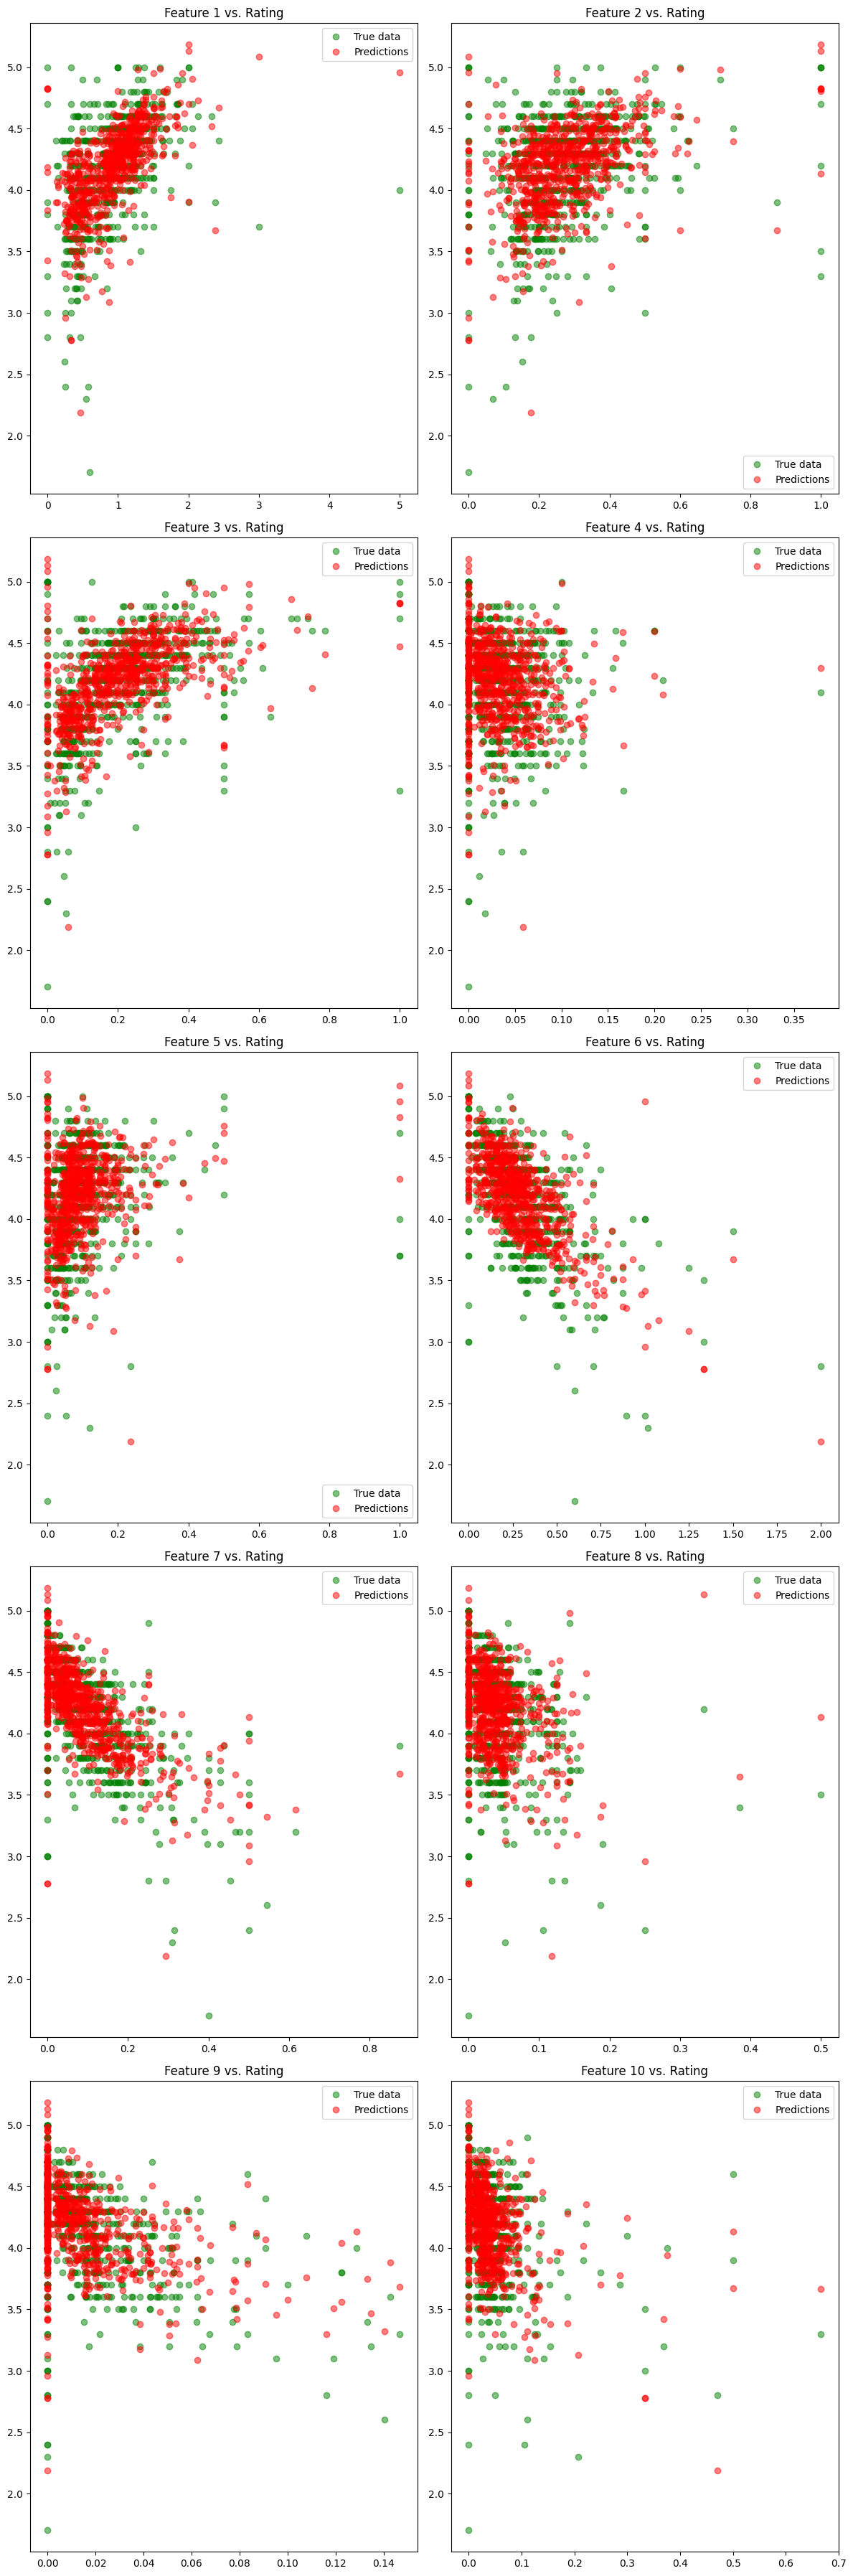

In [8]:
# Predict target variable using test data
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
all_inputs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        predictions = model(inputs).cpu()
        all_predictions.extend(predictions.view(-1).numpy())
        all_labels.extend(labels.cpu().numpy())
        all_inputs.extend(inputs.cpu().numpy())

# Convert to numpy arrays for plotting
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_inputs = np.array(all_inputs)

plt.clf()
fig, axes = plt.subplots(5, 2, figsize=(12, 36))
axes = axes.flatten()

# Plot model predictions with respect to each attribute
for i in range(10):  # Assuming 10 features
    axes[i].plot(all_inputs[:, i], all_labels, 'go', label='True data', alpha=0.5)
    axes[i].plot(all_inputs[:, i], all_predictions, 'ro', label='Predictions', alpha=0.5)
    axes[i].set_title(f'Feature {i+1} vs. Rating')
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()


Mean Squared Error: 0.06431690603494644
Root Mean Squared Error: 0.25360777974128723
R-squared: 0.6355242540773349


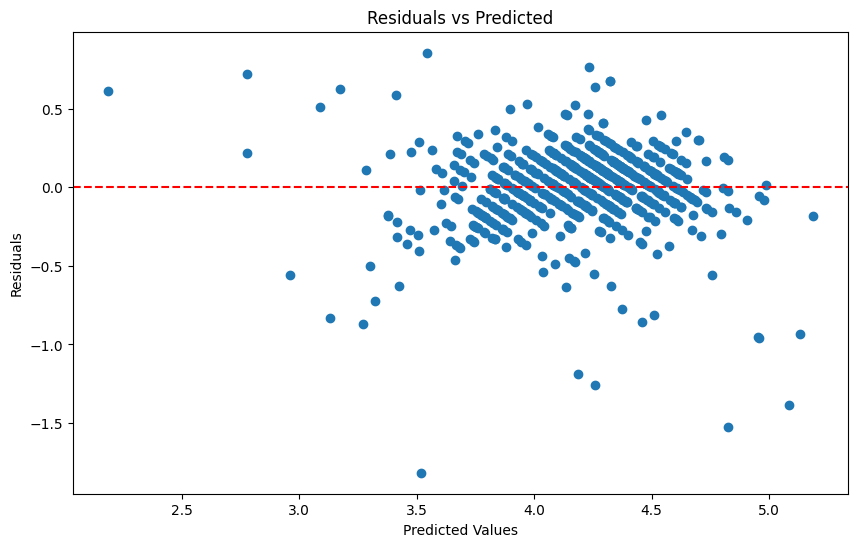

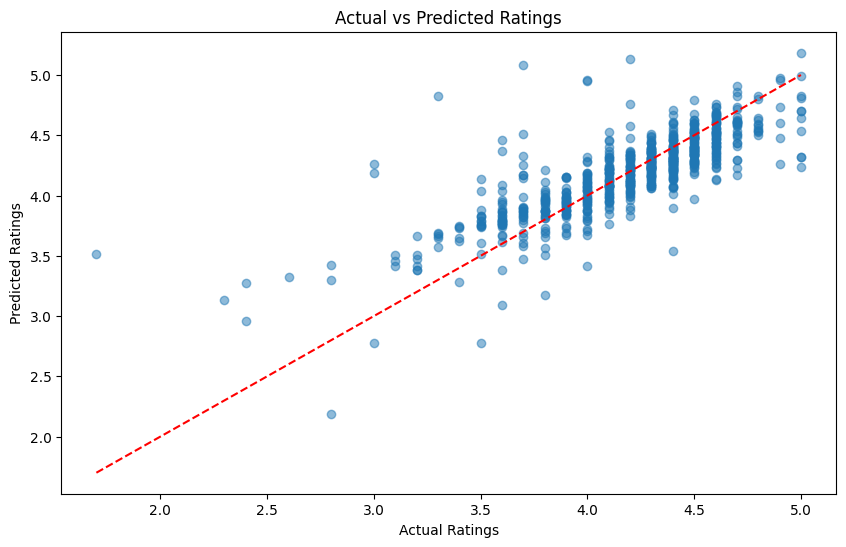

In [9]:
# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

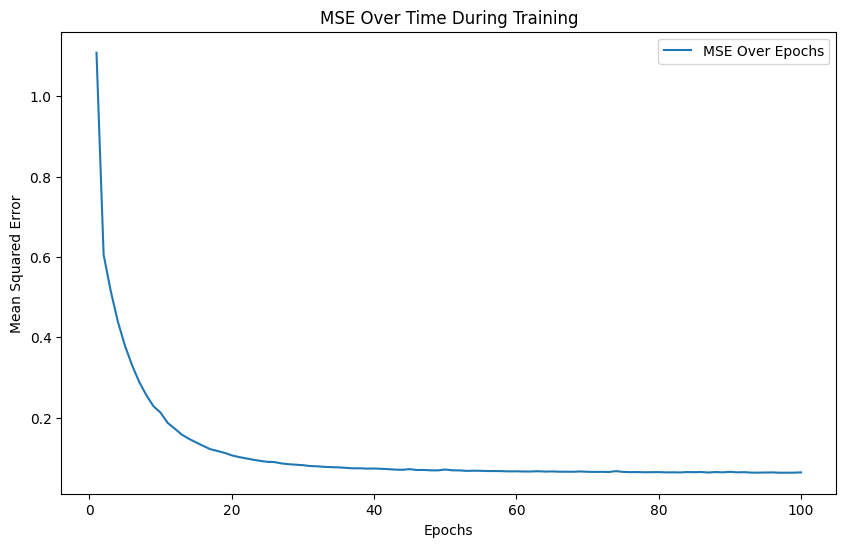

In [10]:
# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

In [13]:
# Assuming 'model' is your trained linear regression model

# Get the weight and bias of the model, ensuring they are moved to CPU
weights = model.linear.weight.data.cpu().numpy().flatten()
bias = model.linear.bias.data.cpu().numpy()

# Assuming you have a list of feature names that corresponds to the columns used in training
feature_names = ['pos_food', 'pos_service', 'pos_location', 'pos_clean', 'pos_price', 
                 'neg_food', 'neg_service', 'neg_location', 'neg_clean', 'neg_price']  # Replace with your actual feature names

# Print weights
for i, weight in enumerate(weights):
    print(f'Feature: {feature_names[i]}, Weight: {weight}')

# Print the bias
print(f'Bias: {bias}')

Feature: pos_food, Weight: 0.3777487277984619
Feature: pos_service, Weight: 0.48396244645118713
Feature: pos_location, Weight: 0.39454349875450134
Feature: pos_clean, Weight: -0.10472362488508224
Feature: pos_price, Weight: 0.0050803967751562595
Feature: neg_food, Weight: -0.8824196457862854
Feature: neg_service, Weight: -0.3154621422290802
Feature: neg_location, Weight: -0.16207048296928406
Feature: neg_clean, Weight: -0.2456076592206955
Feature: neg_price, Weight: -0.34600985050201416
Bias: [3.9453971]


## Regression with Neutral Sentiments

In [38]:
# Load JSON data
with open('restaurant-topic-sentiment-2.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()

# Calculate the size of train and test splits
train_size = int(0.9 * len(data))
test_size = len(data) - train_size

# Split the dataset
train_data, test_data = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Create datasets and dataloaders
train_dataset = CustomDataset(np.array(train_data))
test_dataset = CustomDataset(np.array(test_data))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [44]:
inputDim = 15
outputDim = 1
learningRate = .02
epochs = 150

model = linearRegression(inputDim, outputDim)
##### For GPU #######
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

linearRegression(
  (linear): Linear(in_features=15, out_features=1, bias=True)
)

In [45]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [46]:
mse_history = []

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()

    # Calculate MSE for this epoch and store it
    with torch.no_grad():
        epoch_losses = []
        for inputs, labels in train_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            outputs = model(inputs)
            epoch_loss = criterion(outputs.view(-1), labels)
            epoch_losses.append(epoch_loss.item())
        mse_history.append(np.mean(epoch_losses))

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {mse_history[-1]:.4f}')

Epoch [1/150], Loss: 0.5340
Epoch [2/150], Loss: 0.4100
Epoch [3/150], Loss: 0.3209
Epoch [4/150], Loss: 0.2615
Epoch [5/150], Loss: 0.2204
Epoch [6/150], Loss: 0.1911
Epoch [7/150], Loss: 0.1699
Epoch [8/150], Loss: 0.1546
Epoch [9/150], Loss: 0.1429
Epoch [10/150], Loss: 0.1342
Epoch [11/150], Loss: 0.1269
Epoch [12/150], Loss: 0.1216
Epoch [13/150], Loss: 0.1167
Epoch [14/150], Loss: 0.1128
Epoch [15/150], Loss: 0.1096
Epoch [16/150], Loss: 0.1066
Epoch [17/150], Loss: 0.1042
Epoch [18/150], Loss: 0.1019
Epoch [19/150], Loss: 0.0998
Epoch [20/150], Loss: 0.0983
Epoch [21/150], Loss: 0.0966
Epoch [22/150], Loss: 0.0951
Epoch [23/150], Loss: 0.0939
Epoch [24/150], Loss: 0.0925
Epoch [25/150], Loss: 0.0916
Epoch [26/150], Loss: 0.0905
Epoch [27/150], Loss: 0.0897
Epoch [28/150], Loss: 0.0888
Epoch [29/150], Loss: 0.0882
Epoch [30/150], Loss: 0.0874
Epoch [31/150], Loss: 0.0869
Epoch [32/150], Loss: 0.0863
Epoch [33/150], Loss: 0.0856
Epoch [34/150], Loss: 0.0852
Epoch [35/150], Loss: 0

IndexError: index 10 is out of bounds for axis 0 with size 10

<Figure size 640x480 with 0 Axes>

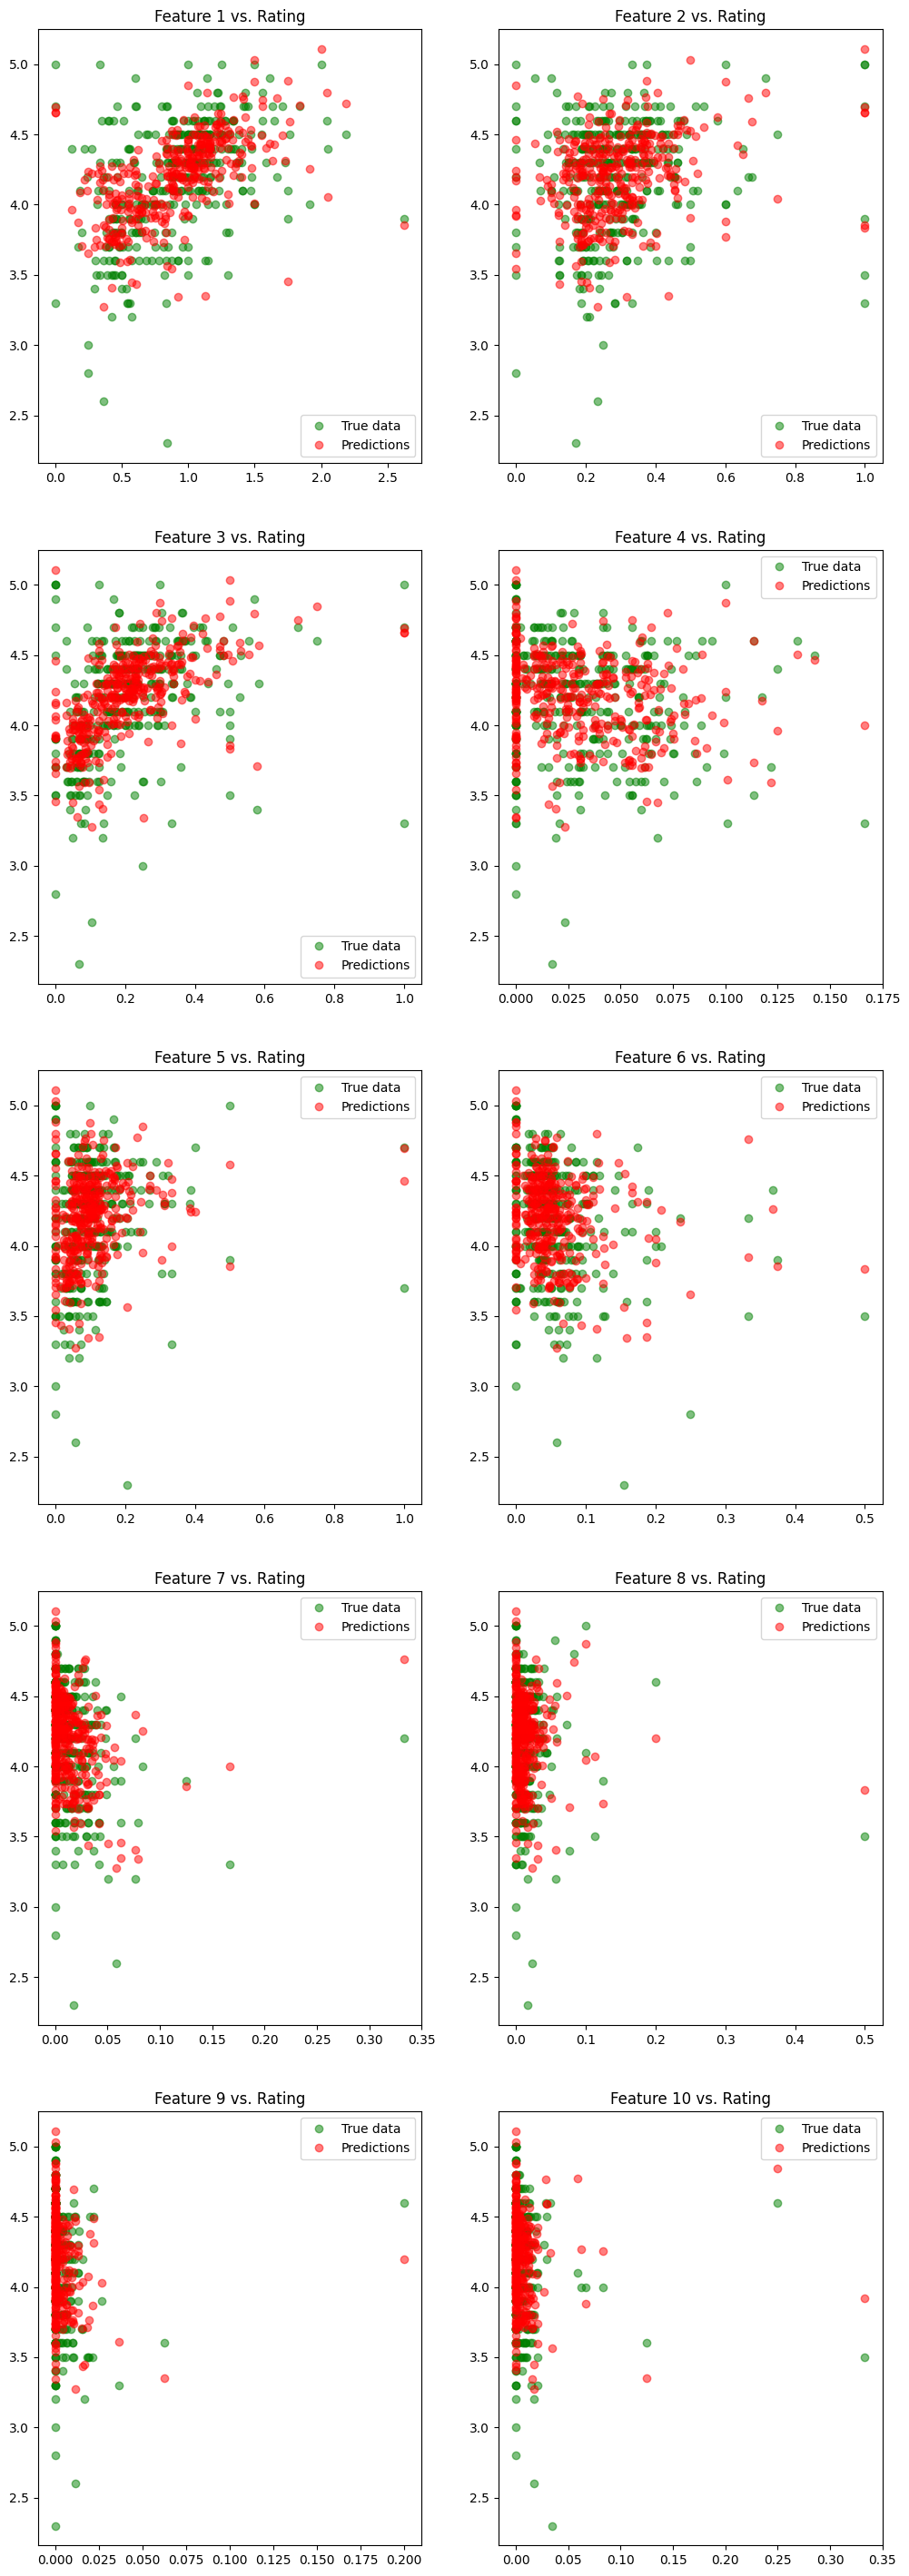

In [42]:
# Predict target variable using test data
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
all_inputs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        predictions = model(inputs).cpu()
        all_predictions.extend(predictions.view(-1).numpy())
        all_labels.extend(labels.cpu().numpy())
        all_inputs.extend(inputs.cpu().numpy())

# Convert to numpy arrays for plotting
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_inputs = np.array(all_inputs)

plt.clf()
fig, axes = plt.subplots(5, 2, figsize=(12, 36))
axes = axes.flatten()

# Plot model predictions with respect to each attribute
for i in range(15):  # Assuming 10 features
    axes[i].plot(all_inputs[:, i], all_labels, 'go', label='True data', alpha=0.5)
    axes[i].plot(all_inputs[:, i], all_predictions, 'ro', label='Predictions', alpha=0.5)
    axes[i].set_title(f'Feature {i+1} vs. Rating')
    axes[i].legend(loc='best')

plt.tight_layout()
plt.show()


Mean Squared Error: 0.07890444248914719
Root Mean Squared Error: 0.2808993458747864
R-squared: 0.5330253442907579


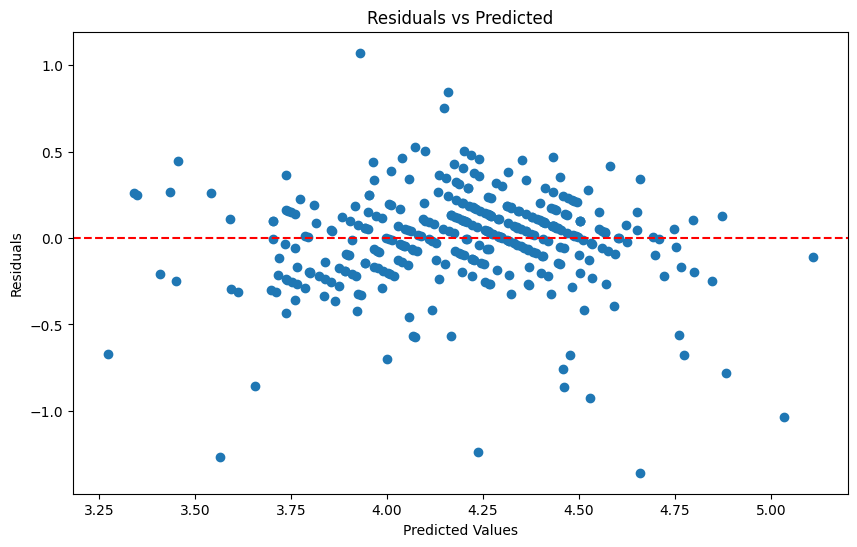

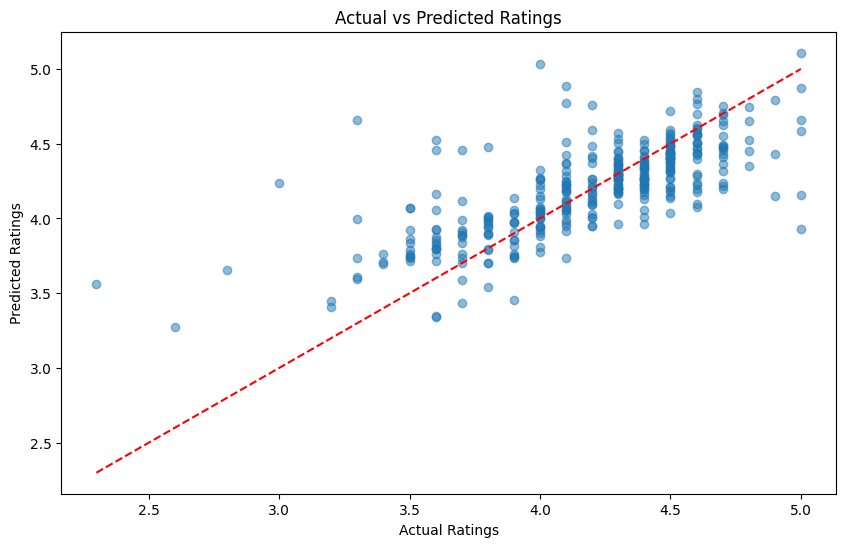

In [47]:
# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = all_labels - all_predictions
plt.scatter(all_predictions, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Comparison Plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')  # line representing perfect predictions
plt.show()

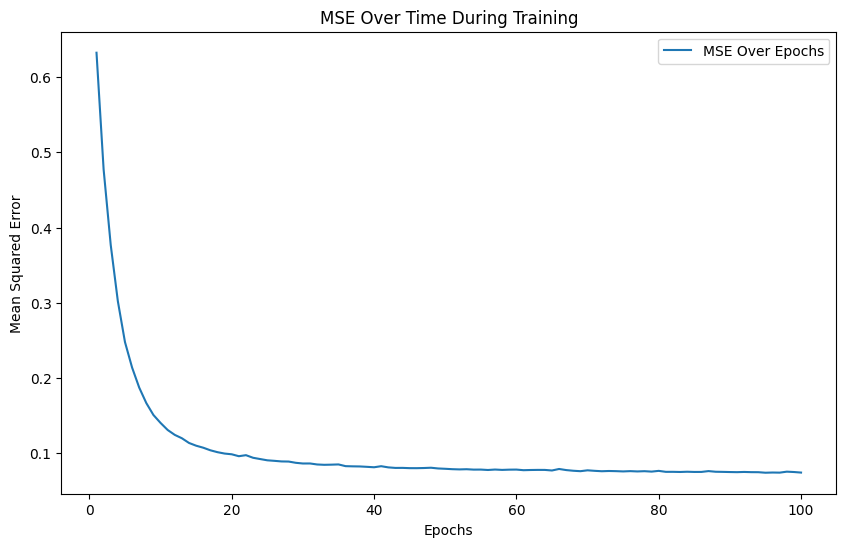

In [37]:
# Plotting the MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()